In this notebook lets experiment with the PI-DeepONet construct. But first let's start by implementing a Vanilla PINN for this problem so we can test some approaches to improve our convergence rates, then we test these approaches in a PI-DeepONet

In [1]:
import os
from typing import Callable
from functools import reduce
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'


import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_device', jax.devices('gpu')[-1])

import jax.numpy as jnp
import numpy as np
import equinox as eqx
from scipy.integrate import odeint
import optax
import h5py
import optuna

import matplotlib.pyplot as plt

# Simulation Results

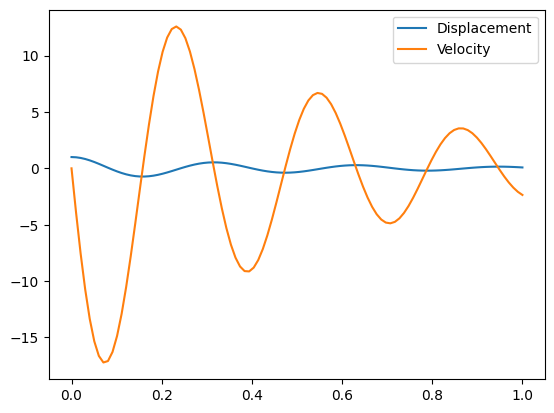

In [2]:
initial_cond = (1., 0.)
x0, v0 = initial_cond

def damped_oscillator_scipy(X, t, beta, k):
    x, v = X
    dxdt = v
    dvdt = -beta * v - k * x
    return [dxdt, dvdt]

ts = np.linspace(0, 1, 100)

beta = 4
k = 400

solution = odeint(damped_oscillator_scipy, initial_cond, ts, args=(beta, k))

xs, vs = solution.T

plt.plot(ts, xs, label="Displacement")
plt.plot(ts, vs, label="Velocity")
plt.legend()

ts = jnp.array(ts)[::2].reshape(-1, 1)
xs = jnp.array(xs)[::2].reshape(-1, 1)

# PINN

Let's start by implementing a PINN so that we can test some techniques for improving physics informed training.

# Model Definition

In [3]:
class MLP(eqx.Module):
    layers: list[eqx.Module]
    activations: list[Callable]

    def __init__(self, layer_sizes: list[int], key: jax.random.PRNGKey):
        """Bla"""

        key, ikey = jax.random.split(key)
        
        self.layers = []

        for n_in, n_out in zip(layer_sizes[0:-1], layer_sizes[1:]):
            
            key, ikey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(n_in, n_out, key=key)
            )

        self.activations = [jax.nn.tanh for _ in range(len(layer_sizes) - 2)]
        self.activations.append(lambda x: x)

            
    def __call__(self, X):
        a = X

        for layer, act in zip(self.layers, self.activations):
            a = act(layer(a))
        
        return a[0]


# Defining Loss Function

I'll be learning a damped oscillator system, so we need to put in the loss function:

$$
\frac{\partial^2 x}{\partial t^2} + \frac{\beta}{m}\frac{\partial x}{\partial t} + \frac{k}{m}x = 0
$$

Setting:

$$
\omega_0 = \sqrt{\frac{k}{m}} \quad \gamma = \sqrt{\frac{\beta}{m}}
$$

With initial conditions:

$$
x(t=0) - x_0 = 0
$$


$$
\frac{\partial x}{\partial t}(t=0) - v_0 = 0
$$


In [4]:

def ode(model, X):
    """Pendulum mass-spring ODE"""
    
    x, x_t = eqx.filter_value_and_grad(model)(X)
    x_tt = eqx.filter_grad(lambda x: eqx.filter_grad(model)(x)[0])(X)
    ode = x_tt + beta*x_t + k*x
    
    return ode


def individual_losses(model, X):    
    """Full set of individual losses for mass-spring"""
    
    physics = jnp.mean(jnp.square(jax.vmap(ode, in_axes=(None, 0))(model, X)))
    x, x_t = eqx.filter_value_and_grad(model)(X[0])
    x_ini = jnp.mean(jnp.square(x - x0))
    v_ini = jnp.mean(jnp.square(x_t - v0))

    return jnp.array([x_ini, v_ini, physics])
    

def loss_fn_physics(model, X, lambdas):
    """Aggregation function for losses"""
    return jnp.sum(individual_losses(model, X)*lambdas)


def loss_fn_data(model, X, Y):
    res = jax.vmap(model)(X) - Y
    return jnp.mean(res**2)


@eqx.filter_jit
def update(opt_state, model, X, Y, key):
    

    loss, grad = eqx.filter_value_and_grad(loss_fn_physics)(model)
    updates, new_state = optmizer.update(grad, opt_state, model)
    new_model = eqx.apply_updates(model, updates)

    return loss, new_model, new_state




# ReLoBRaLo Functions

def _softmax(L, tau):
    shift = jnp.max(L/tau)
    arg = jnp.exp(L/tau - shift)
    return arg/jnp.sum(arg)

def relative_weights(current_losses, reference_losses, tau = 1.0):
    m =len(current_losses)
    L = current_losses/reference_losses
    return m*_softmax(L, tau)


def relobralo(key, current_losses, past_losses, last_lambda, first_losses, tau = 0.1, alpha = 0.95, rho_p = 0.99):
    """ReLoBRaLo logic"""
    
    lambda_ttm1 = relative_weights(current_losses, past_losses, tau=tau)
    rho = jax.random.bernoulli(key)
    rho = jax.lax.cond(rho, lambda _: 1.0, lambda _: 0.0, operand=None)

    lambda_past = rho*last_lambda + (1.0 - rho)*relative_weights(current_losses, first_losses, tau=tau)

    return alpha*lambda_past + (1.0 - alpha)*lambda_ttm1


@eqx.filter_jit
def update_relobralo(opt_state, model, X, weights, first_losses, key):

    
    losses = individual_losses(model, X)
    
    total_loss, grad = eqx.filter_value_and_grad(loss_fn_physics)(model, X, weights)
    updates, new_state = optmizer.update(grad, opt_state, model)
    new_model = eqx.apply_updates(model, updates)

    new_weights = relobralo(key, individual_losses(new_model, X), losses, weights, first_losses)

    return total_loss, new_model, new_state, new_weights
    

In [5]:
key = jax.random.key(123)
layers = [1,] + [32,]*3+ [1,]
pinn = MLP(layers, key)
total_losses = []
initial_losses = individual_losses(pinn, ts)
weights = jnp.array([1., 1., 1.])

In [6]:
# from copy import deepcopy

# optmizer = optax.adam(0.001)
# opt_state = optmizer.init(eqx.filter(pinn, eqx.is_array))

# min_loss = min(total_losses) if total_losses else 1_000_000


# key = jax.random.key(423)

# for epoch in range(20_001):

#     key, ekey = jax.random.split(key)

#     total_loss, pinn, opt_state, weights = update_relobralo(opt_state, pinn, ts, weights, initial_losses, ekey)
    
#     total_losses.append(total_loss)

#     if epoch % 1000 == 0:
#         print(f"{epoch = } | {total_loss = }")


#     if total_loss < min_loss and epoch > 1_999:
#         # print(f"Best model  at step: {len(losses)} | {loss = }")
#         best_model = deepcopy(pinn)
#         min_loss = total_loss

# Testing loss function weighting using optuna

In [7]:
from copy import deepcopy

def loss_fn_physics(model, X, lambdas):
    """Aggregation function for losses"""
    return jnp.sum(individual_losses(model, X)*lambdas)


@eqx.filter_jit
def update(opt_state, model, X, lambdas, optimizer):
    

    loss, grad = eqx.filter_value_and_grad(loss_fn_physics)(model, X, lambdas)
    updates, new_state = optimizer.update(grad, opt_state, model)
    new_model = eqx.apply_updates(model, updates)

    return loss, new_model, new_state




def objective(trial):
    
    print(f"Executing trial {trial.number}")

    key = jax.random.key(123)
    layers = [1,] + [32,]*3+ [1,]
    pinn = MLP(layers, key)
    total_losses = []

    x = trial.suggest_float("x", 0, 1)
    y = trial.suggest_float("y", 0, 1 - x)
    z = 1 - (x + y)

    lambdas = jnp.array([x, y, z])
    
    
    optimizer = optax.adam(0.001)
    opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))
    
    min_loss = min(total_losses) if total_losses else 1_000_000
    
    
    key = jax.random.key(423)
    
    for epoch in range(5_001):
    
        key, ekey = jax.random.split(key)
    
        total_loss, pinn, opt_state = update(opt_state, pinn, ts, lambdas, optimizer)
        
        total_losses.append(total_loss)
    
        # if epoch % 1000 == 0:
        #     print(f"{epoch = } | {total_loss = }")
    
    
        if total_loss < min_loss and epoch > 1_999:
            # print(f"Best model  at step: {len(losses)} | {loss = }")
            # best_model = deepcopy(pinn)
            min_loss = total_loss

    print(f"{min_loss = }")

    return total_loss +  jnp.square(pinn(ts[0]) - x0)


study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100)

[I 2025-09-12 21:41:06,522] A new study created in memory with name: no-name-2873e4f6-9f10-4cc8-9523-84a94d113d88


Executing trial 0
min_loss = Array(0.43589679, dtype=float64)


[I 2025-09-12 21:41:17,564] Trial 0 finished with value: 1.4351113418129184 and parameters: {'x': 0.43608931478245994, 'y': 0.49416197998736494}. Best is trial 0 with value: 1.4351113418129184.


Executing trial 1


[I 2025-09-12 21:41:28,246] Trial 1 finished with value: 1.8645759951842664 and parameters: {'x': 0.8677208948013627, 'y': 0.07862719978758054}. Best is trial 0 with value: 1.4351113418129184.


min_loss = Array(0.86668656, dtype=float64)
Executing trial 2


[I 2025-09-12 21:41:39,023] Trial 2 finished with value: 1.2508974362192318 and parameters: {'x': 0.25088402446377944, 'y': 0.04138576277520666}. Best is trial 2 with value: 1.2508974362192318.


min_loss = Array(0.25090792, dtype=float64)
Executing trial 3


[I 2025-09-12 21:41:49,632] Trial 3 finished with value: 1.7433834757675246 and parameters: {'x': 0.743894186986183, 'y': 0.007726945537159046}. Best is trial 2 with value: 1.2508974362192318.


min_loss = Array(0.74374553, dtype=float64)
Executing trial 4


[I 2025-09-12 21:42:00,128] Trial 4 finished with value: 1.354186973563632 and parameters: {'x': 0.3542120115868056, 'y': 0.019167399121257468}. Best is trial 2 with value: 1.2508974362192318.


min_loss = Array(0.35422554, dtype=float64)
Executing trial 5


[I 2025-09-12 21:42:10,432] Trial 5 finished with value: 1.420098686539618 and parameters: {'x': 0.42024370389395116, 'y': 0.23298505729684427}. Best is trial 2 with value: 1.2508974362192318.


min_loss = Array(0.4202237, dtype=float64)
Executing trial 6


[I 2025-09-12 21:42:20,925] Trial 6 finished with value: 1.8850372769303085 and parameters: {'x': 0.8900005804174368, 'y': 0.07464171315018804}. Best is trial 2 with value: 1.2508974362192318.


min_loss = Array(0.88834246, dtype=float64)
Executing trial 7


[I 2025-09-12 21:42:31,328] Trial 7 finished with value: 1.6242650670237206 and parameters: {'x': 0.6253583104512712, 'y': 0.2768123466806215}. Best is trial 2 with value: 1.2508974362192318.


min_loss = Array(0.6250732, dtype=float64)
Executing trial 8


[I 2025-09-12 21:42:42,042] Trial 8 finished with value: 1.4267508322716749 and parameters: {'x': 0.4271267829759525, 'y': 0.40743144674290305}. Best is trial 2 with value: 1.2508974362192318.


min_loss = Array(0.42705621, dtype=float64)
Executing trial 9


[I 2025-09-12 21:42:52,756] Trial 9 finished with value: 1.5205877946223998 and parameters: {'x': 0.5239324422592738, 'y': 0.4503965066569289}. Best is trial 2 with value: 1.2508974362192318.


min_loss = Array(0.5231774, dtype=float64)
Executing trial 10


[I 2025-09-12 21:43:03,618] Trial 10 finished with value: 1.0628064395410821 and parameters: {'x': 0.06283429481025637, 'y': 0.8142474600740252}. Best is trial 10 with value: 1.0628064395410821.


min_loss = Array(0.06283743, dtype=float64)
Executing trial 11


[I 2025-09-12 21:43:14,363] Trial 11 finished with value: 1.03085156219578 and parameters: {'x': 0.03084145016515049, 'y': 0.8383027146816137}. Best is trial 11 with value: 1.03085156219578.


min_loss = Array(0.03084635, dtype=float64)
Executing trial 12


[I 2025-09-12 21:43:25,085] Trial 12 finished with value: 1.0066062277041987 and parameters: {'x': 0.006573268851547562, 'y': 0.87948246285149}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.00657747, dtype=float64)
Executing trial 13


[I 2025-09-12 21:43:35,605] Trial 13 finished with value: 1.0131114156875 and parameters: {'x': 0.013548395625585522, 'y': 0.9839468919883576}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.01354552, dtype=float64)
Executing trial 14


[I 2025-09-12 21:43:46,376] Trial 14 finished with value: 1.2096420402884633 and parameters: {'x': 0.2098964054602212, 'y': 0.6866159552994264}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.20987172, dtype=float64)
Executing trial 15


[I 2025-09-12 21:43:57,066] Trial 15 finished with value: 1.1512610333837536 and parameters: {'x': 0.1513444568262034, 'y': 0.6791989920685222}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.15134275, dtype=float64)
Executing trial 16


[I 2025-09-12 21:44:07,770] Trial 16 finished with value: 1.0086898536809876 and parameters: {'x': 0.00870777833268932, 'y': 0.9712747386939335}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.0087084, dtype=float64)
Executing trial 17


[I 2025-09-12 21:44:18,498] Trial 17 finished with value: 1.2941994675459543 and parameters: {'x': 0.2944735656664645, 'y': 0.5638843702607083}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.29443728, dtype=float64)
Executing trial 18


[I 2025-09-12 21:44:29,187] Trial 18 finished with value: 1.1478674857052094 and parameters: {'x': 0.14977433286288055, 'y': 0.8406669370780369}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.14963375, dtype=float64)
Executing trial 19


[I 2025-09-12 21:44:40,002] Trial 19 finished with value: 1.1216123557694733 and parameters: {'x': 0.12167436622842104, 'y': 0.7189198527487033}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.1216754, dtype=float64)
Executing trial 20


[I 2025-09-12 21:44:50,779] Trial 20 finished with value: 1.5661191840810562 and parameters: {'x': 0.5664106194287519, 'y': 0.14717016208406855}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.5663449, dtype=float64)
Executing trial 21


[I 2025-09-12 21:45:01,534] Trial 21 finished with value: 1.0141713285025327 and parameters: {'x': 0.014194881933487526, 'y': 0.9558905167877169}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.01419574, dtype=float64)
Executing trial 22


[I 2025-09-12 21:45:12,274] Trial 22 finished with value: 1.085872252295502 and parameters: {'x': 0.08709098654236541, 'y': 0.9048390217135245}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.08703783, dtype=float64)
Executing trial 23


[I 2025-09-12 21:45:22,967] Trial 23 finished with value: 1.0070091088310025 and parameters: {'x': 0.007051298983142581, 'y': 0.9823279143029545}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.00705152, dtype=float64)
Executing trial 24


[I 2025-09-12 21:45:33,641] Trial 24 finished with value: 1.1933555310393527 and parameters: {'x': 0.19372934177167445, 'y': 0.7386847413752964}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.19369381, dtype=float64)
Executing trial 25


[I 2025-09-12 21:45:44,449] Trial 25 finished with value: 1.2614121207789348 and parameters: {'x': 0.2616935822148018, 'y': 0.6165647044448771}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.26165968, dtype=float64)
Executing trial 26


[I 2025-09-12 21:45:55,285] Trial 26 finished with value: 1.0959729355894583 and parameters: {'x': 0.09604116853322657, 'y': 0.7830614255171096}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.09604133, dtype=float64)
Executing trial 27


[I 2025-09-12 21:46:06,081] Trial 27 finished with value: 1.3487452432994476 and parameters: {'x': 0.3496655290259665, 'y': 0.5936626395883378}. Best is trial 12 with value: 1.0066062277041987.


min_loss = Array(0.34951481, dtype=float64)
Executing trial 28


[I 2025-09-12 21:46:16,875] Trial 28 finished with value: 0.0038668229531607866 and parameters: {'x': 0.9739569004976617, 'y': 0.026013442202360793}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00384634, dtype=float64)
Executing trial 29


[I 2025-09-12 21:46:27,668] Trial 29 finished with value: 1.77343941873511 and parameters: {'x': 0.7768278224419394, 'y': 0.18033836766499833}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.77579667, dtype=float64)
Executing trial 30


[I 2025-09-12 21:46:38,365] Trial 30 finished with value: 1.9672567461281605 and parameters: {'x': 0.9755356318698755, 'y': 7.697269457066641e-05}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.97259604, dtype=float64)
Executing trial 31


[I 2025-09-12 21:46:49,413] Trial 31 finished with value: 1.6600163638153773 and parameters: {'x': 0.6622890268353053, 'y': 0.2861922987031357}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.66167176, dtype=float64)
Executing trial 32


[I 2025-09-12 21:47:00,353] Trial 32 finished with value: 1.9594010256775958 and parameters: {'x': 0.9831756405792478, 'y': 0.006340965335350689}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.97497286, dtype=float64)
Executing trial 33


[I 2025-09-12 21:47:11,112] Trial 33 finished with value: 1.1620107661688304 and parameters: {'x': 0.16225096904235672, 'y': 0.7553235356253473}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.16223267, dtype=float64)
Executing trial 34


[I 2025-09-12 21:47:21,841] Trial 34 finished with value: 1.082085619949885 and parameters: {'x': 0.08230857762509838, 'y': 0.8754591430369538}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.08229984, dtype=float64)
Executing trial 35


[I 2025-09-12 21:47:32,628] Trial 35 finished with value: 1.835058640815426 and parameters: {'x': 0.8364755000822728, 'y': 0.052464445922057346}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.83602038, dtype=float64)
Executing trial 36


[I 2025-09-12 21:47:43,265] Trial 36 finished with value: 1.3197445835812425 and parameters: {'x': 0.3206652322501951, 'y': 0.6283598795221091}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.32052533, dtype=float64)
Executing trial 37


[I 2025-09-12 21:47:53,868] Trial 37 finished with value: 1.2171423773552932 and parameters: {'x': 0.21721625180977988, 'y': 0.5198125442835271}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.21721557, dtype=float64)
Executing trial 38


[I 2025-09-12 21:48:04,424] Trial 38 finished with value: 1.0022883939821323 and parameters: {'x': 0.002254115610185968, 'y': 0.925158901899157}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00225674, dtype=float64)
Executing trial 39


[I 2025-09-12 21:48:15,123] Trial 39 finished with value: 1.4539768602692613 and parameters: {'x': 0.454294849306303, 'y': 0.33962965925462335}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.45423326, dtype=float64)
Executing trial 40


[I 2025-09-12 21:48:25,965] Trial 40 finished with value: 1.6735913378443645 and parameters: {'x': 0.6741672396565491, 'y': 0.12888181669894178}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.67401004, dtype=float64)
Executing trial 41


[I 2025-09-12 21:48:36,756] Trial 41 finished with value: 1.046506176931043 and parameters: {'x': 0.04660143197604848, 'y': 0.907355949000457}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.04660042, dtype=float64)
Executing trial 42


[I 2025-09-12 21:48:47,514] Trial 42 finished with value: 1.1144396835667596 and parameters: {'x': 0.11461104630222599, 'y': 0.8105378078897033}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.11460264, dtype=float64)
Executing trial 43


[I 2025-09-12 21:48:58,219] Trial 43 finished with value: 1.0057448371383617 and parameters: {'x': 0.005722776278126012, 'y': 0.9455879213176788}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00572461, dtype=float64)
Executing trial 44


[I 2025-09-12 21:49:09,052] Trial 44 finished with value: 1.0515118588876435 and parameters: {'x': 0.0516023117834804, 'y': 0.8952790112670453}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.0516014, dtype=float64)
Executing trial 45


[I 2025-09-12 21:49:19,690] Trial 45 finished with value: 1.0119100759247748 and parameters: {'x': 0.011903229005468693, 'y': 0.9383184296897776}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.01190509, dtype=float64)
Executing trial 46


[I 2025-09-12 21:49:30,423] Trial 46 finished with value: 1.0612264137888776 and parameters: {'x': 0.06128430232815391, 'y': 0.8544536297041821}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.06128507, dtype=float64)
Executing trial 47


[I 2025-09-12 21:49:41,181] Trial 47 finished with value: 1.3997497401154206 and parameters: {'x': 0.4016309604701647, 'y': 0.5655003819045986}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.4012869, dtype=float64)
Executing trial 48


[I 2025-09-12 21:49:51,678] Trial 48 finished with value: 1.88134467828367 and parameters: {'x': 0.8832684016705541, 'y': 0.027695895578973565}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.88262707, dtype=float64)
Executing trial 49


[I 2025-09-12 21:50:02,410] Trial 49 finished with value: 1.17414943534967 and parameters: {'x': 0.17476660924887608, 'y': 0.7878589790567357}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.17471238, dtype=float64)
Executing trial 50


[I 2025-09-12 21:50:13,113] Trial 50 finished with value: 1.2425292495751294 and parameters: {'x': 0.2431447975488407, 'y': 0.7022903844546691}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.24307162, dtype=float64)
Executing trial 51


[I 2025-09-12 21:50:23,849] Trial 51 finished with value: 1.0060612430159916 and parameters: {'x': 0.006132718154206839, 'y': 0.9876641983084571}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00613271, dtype=float64)
Executing trial 52


[I 2025-09-12 21:50:34,574] Trial 52 finished with value: 1.122727347844847 and parameters: {'x': 0.12297394785239872, 'y': 0.8175227315227975}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.12295941, dtype=float64)
Executing trial 53


[I 2025-09-12 21:50:45,211] Trial 53 finished with value: 1.0095189294369642 and parameters: {'x': 0.009771078810647559, 'y': 0.9870855423071297}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00976995, dtype=float64)
Executing trial 54


[I 2025-09-12 21:50:55,900] Trial 54 finished with value: 1.0455420826590887 and parameters: {'x': 0.04571123641919249, 'y': 0.9257446144560973}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.04570788, dtype=float64)
Executing trial 55


[I 2025-09-12 21:51:06,643] Trial 55 finished with value: 1.0020243051113846 and parameters: {'x': 0.0020535589397195795, 'y': 0.9948917746304806}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00205362, dtype=float64)
Executing trial 56


[I 2025-09-12 21:51:17,441] Trial 56 finished with value: 1.0829896938693835 and parameters: {'x': 0.0832153637568471, 'y': 0.8744775063905834}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.08320639, dtype=float64)
Executing trial 57


[I 2025-09-12 21:51:28,209] Trial 57 finished with value: 1.5397274972610075 and parameters: {'x': 0.5496608337604522, 'y': 0.4415197741217549}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.54737928, dtype=float64)
Executing trial 58


[I 2025-09-12 21:51:39,184] Trial 58 finished with value: 1.1231990950368833 and parameters: {'x': 0.12346479383335161, 'y': 0.8205581822037418}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.12344885, dtype=float64)
Executing trial 59


[I 2025-09-12 21:51:49,904] Trial 59 finished with value: 1.0008721886470417 and parameters: {'x': 0.0008362839789711803, 'y': 0.9426248044184327}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.0008383, dtype=float64)
Executing trial 60


[I 2025-09-12 21:52:00,724] Trial 60 finished with value: 1.047745090488914 and parameters: {'x': 0.047930702257610286, 'y': 0.9243343548112374}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.04792669, dtype=float64)
Executing trial 61


[I 2025-09-12 21:52:11,513] Trial 61 finished with value: 1.0799296200682973 and parameters: {'x': 0.08013801149783191, 'y': 0.8763216121356638}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.08013019, dtype=float64)
Executing trial 62


[I 2025-09-12 21:52:22,365] Trial 62 finished with value: 1.004355855625791 and parameters: {'x': 0.0043325000776368635, 'y': 0.9552251410171321}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00433401, dtype=float64)
Executing trial 63


[I 2025-09-12 21:52:32,770] Trial 63 finished with value: 1.1522063368127085 and parameters: {'x': 0.15250176661615641, 'y': 0.7832443282415205}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.15247976, dtype=float64)
Executing trial 64


[I 2025-09-12 21:52:42,997] Trial 64 finished with value: 1.0245753307678278 and parameters: {'x': 0.02463452079595134, 'y': 0.9424677409923227}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.0246348, dtype=float64)
Executing trial 65


[I 2025-09-12 21:52:53,395] Trial 65 finished with value: 1.0026094676600255 and parameters: {'x': 0.002602920532101565, 'y': 0.9863567273492038}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00260331, dtype=float64)
Executing trial 66


[I 2025-09-12 21:53:03,797] Trial 66 finished with value: 1.1190692381678757 and parameters: {'x': 0.11951578174447325, 'y': 0.8471556228707163}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.11948863, dtype=float64)
Executing trial 67


[I 2025-09-12 21:53:14,220] Trial 67 finished with value: 1.0706621393211577 and parameters: {'x': 0.07093219844888182, 'y': 0.8987757365644468}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.07092272, dtype=float64)
Executing trial 68


[I 2025-09-12 21:53:24,570] Trial 68 finished with value: 1.5890965266584034 and parameters: {'x': 0.6109392382297139, 'y': 0.384209461977701}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.60579533, dtype=float64)
Executing trial 69


[I 2025-09-12 21:53:34,772] Trial 69 finished with value: 1.7332242717892683 and parameters: {'x': 0.7339907365294353, 'y': 0.09852066142590404}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.73376713, dtype=float64)
Executing trial 70


[I 2025-09-12 21:53:45,696] Trial 70 finished with value: 1.942500572632686 and parameters: {'x': 0.9494170096570551, 'y': 0.022590026969054208}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.94700468, dtype=float64)
Executing trial 71


[I 2025-09-12 21:53:56,449] Trial 71 finished with value: 1.040571555750392 and parameters: {'x': 0.04069777776512439, 'y': 0.9270249744573757}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.04069594, dtype=float64)
Executing trial 72


[I 2025-09-12 21:54:07,213] Trial 72 finished with value: 1.0090669809457085 and parameters: {'x': 0.009077732828894987, 'y': 0.9666937673881468}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00907854, dtype=float64)
Executing trial 73


[I 2025-09-12 21:54:18,245] Trial 73 finished with value: 1.0007847862281432 and parameters: {'x': 0.0007504064741327874, 'y': 0.961768873406634}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00075174, dtype=float64)
Executing trial 74


[I 2025-09-12 21:54:29,050] Trial 74 finished with value: 1.1066115827327947 and parameters: {'x': 0.1069848080421587, 'y': 0.8579208876523257}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.10696456, dtype=float64)
Executing trial 75


[I 2025-09-12 21:54:39,718] Trial 75 finished with value: 1.4646149474590406 and parameters: {'x': 0.47232306341163705, 'y': 0.5183926687708589}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.47075455, dtype=float64)
Executing trial 76


[I 2025-09-12 21:54:50,612] Trial 76 finished with value: 1.0364516618499038 and parameters: {'x': 0.03661711376277083, 'y': 0.9404577703611906}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.03661452, dtype=float64)
Executing trial 77


[I 2025-09-12 21:55:01,454] Trial 77 finished with value: 1.0666440844221987 and parameters: {'x': 0.06684071380163784, 'y': 0.8954725027234712}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.06683465, dtype=float64)
Executing trial 78


[I 2025-09-12 21:55:12,096] Trial 78 finished with value: 1.0322012840342993 and parameters: {'x': 0.03214215619006462, 'y': 0.21032684734132556}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.03216999, dtype=float64)
Executing trial 79


[I 2025-09-12 21:55:22,730] Trial 79 finished with value: 1.0957459433502392 and parameters: {'x': 0.09598593523383225, 'y': 0.8575550844770159}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.09597488, dtype=float64)
Executing trial 80


[I 2025-09-12 21:55:33,505] Trial 80 finished with value: 1.1319695511900454 and parameters: {'x': 0.13238567422105194, 'y': 0.827573595275755}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.1323578, dtype=float64)
Executing trial 81


[I 2025-09-12 21:55:44,267] Trial 81 finished with value: 1.0040556747792304 and parameters: {'x': 0.004145565451550318, 'y': 0.9927559254276959}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00414547, dtype=float64)
Executing trial 82


[I 2025-09-12 21:55:55,101] Trial 82 finished with value: 1.0049714437394355 and parameters: {'x': 0.004952877186701076, 'y': 0.9605707789773067}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00495417, dtype=float64)
Executing trial 83


[I 2025-09-12 21:56:05,933] Trial 83 finished with value: 1.0008688463302684 and parameters: {'x': 0.0008631331125195681, 'y': 0.9961110862511945}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00086322, dtype=float64)
Executing trial 84


[I 2025-09-12 21:56:16,751] Trial 84 finished with value: 1.0617918832249593 and parameters: {'x': 0.06205228444749129, 'y': 0.9109233262526358}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.06204434, dtype=float64)
Executing trial 85


[I 2025-09-12 21:56:27,563] Trial 85 finished with value: 1.0260479589796472 and parameters: {'x': 0.026183387651076022, 'y': 0.9548879046734154}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.02618207, dtype=float64)
Executing trial 86


[I 2025-09-12 21:56:38,259] Trial 86 finished with value: 1.0922021969649984 and parameters: {'x': 0.09252544182778434, 'y': 0.8732900756485621}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.0925104, dtype=float64)
Executing trial 87


[I 2025-09-12 21:56:49,131] Trial 87 finished with value: 1.1792916541877256 and parameters: {'x': 0.18031800445344717, 'y': 0.7964629753178829}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.18022559, dtype=float64)
Executing trial 88


[I 2025-09-12 21:57:00,026] Trial 88 finished with value: 1.000973588784356 and parameters: {'x': 0.0009470987226771591, 'y': 0.9846278666642273}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00094761, dtype=float64)
Executing trial 89


[I 2025-09-12 21:57:11,066] Trial 89 finished with value: 1.0606976737605633 and parameters: {'x': 0.06087500848929343, 'y': 0.9018763645559891}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.06087022, dtype=float64)
Executing trial 90


[I 2025-09-12 21:57:21,905] Trial 90 finished with value: 1.0328907645146748 and parameters: {'x': 0.032958036788517685, 'y': 0.9260915254249674}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.03295814, dtype=float64)
Executing trial 91


[I 2025-09-12 21:57:32,663] Trial 91 finished with value: 1.0005509482886106 and parameters: {'x': 0.000520188645783662, 'y': 0.9830035120309324}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00052076, dtype=float64)
Executing trial 92


[I 2025-09-12 21:57:43,476] Trial 92 finished with value: 1.0351720329725498 and parameters: {'x': 0.03523013145447107, 'y': 0.916594597970552}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.03523057, dtype=float64)
Executing trial 93


[I 2025-09-12 21:57:54,281] Trial 93 finished with value: 1.0014329948783087 and parameters: {'x': 0.0014223140200491306, 'y': 0.9915928441864639}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.00142255, dtype=float64)
Executing trial 94


[I 2025-09-12 21:58:05,125] Trial 94 finished with value: 0.07925675240609874 and parameters: {'x': 0.8378134322092217, 'y': 0.1617657229970939}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.06958422, dtype=float64)
Executing trial 95


[I 2025-09-12 21:58:15,960] Trial 95 finished with value: 1.840183230765283 and parameters: {'x': 0.8418819158043702, 'y': 0.0636200470317597}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.84133344, dtype=float64)
Executing trial 96


[I 2025-09-12 21:58:26,798] Trial 96 finished with value: 1.9107356568292304 and parameters: {'x': 0.9149349645731658, 'y': 0.04174927570881309}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.9135048, dtype=float64)
Executing trial 97


[I 2025-09-12 21:58:37,590] Trial 97 finished with value: 1.9475744587825576 and parameters: {'x': 0.9519580247382452, 'y': 0.004093138548498916}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.9504249, dtype=float64)
Executing trial 98


[I 2025-09-12 21:58:48,451] Trial 98 finished with value: 1.5976297483837651 and parameters: {'x': 0.9960691019260819, 'y': 0.0018068114276724044}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.85103606, dtype=float64)
Executing trial 99


[I 2025-09-12 21:58:59,378] Trial 99 finished with value: 1.4599100442040962 and parameters: {'x': 0.7094494929420455, 'y': 0.28925916171294264}. Best is trial 28 with value: 0.0038668229531607866.


min_loss = Array(0.62905012, dtype=float64)


In [8]:
print('Minimum objective value: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

Minimum objective value: 0.0038668229531607866
Best parameter: {'x': 0.9739569004976617, 'y': 0.026013442202360793}


In [20]:
x, y = study.best_params.values()
z = 1 - (x + y)

x, y, z

(2.203106863312202e-05, 0.9673932295368455, 0.032584739394521445)

In [13]:
key = jax.random.key(123)
layers = [1,] + [32,]*3+ [1,]
pinn = MLP(layers, key)
total_losses = []

x, y = study.best_params.values()
z = 1 - (x + y)

# lambdas = jnp.array([1.0, 0.1, 0.0001])  # moseley
lambdas = jnp.array([x, y, z]) 


optimizer = optax.adam(0.001)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

min_loss = min(total_losses) if total_losses else 1_000_000


key = jax.random.key(423)

for epoch in range(15_001 - len(total_losses)):

    key, ekey = jax.random.split(key)

    total_loss, pinn, opt_state = update(opt_state, pinn, ts, lambdas, optimizer)
    
    total_losses.append(total_loss)

    if epoch % 1000 == 0:
        print(f"{epoch = } | {total_loss = }")


    if total_loss < min_loss and epoch > 1_999:
        # print(f"Best model  at step: {len(losses)} | {loss = }")
        best_model = deepcopy(pinn)
        min_loss = total_loss



epoch = 0 | total_loss = Array(1.35054671, dtype=float64)
epoch = 1000 | total_loss = Array(0.02645134, dtype=float64)
epoch = 2000 | total_loss = Array(0.01261842, dtype=float64)
epoch = 3000 | total_loss = Array(0.00860305, dtype=float64)
epoch = 4000 | total_loss = Array(0.00639333, dtype=float64)
epoch = 5000 | total_loss = Array(0.00384634, dtype=float64)
epoch = 6000 | total_loss = Array(0.00596938, dtype=float64)
epoch = 7000 | total_loss = Array(0.00216398, dtype=float64)
epoch = 8000 | total_loss = Array(0.00114119, dtype=float64)
epoch = 9000 | total_loss = Array(0.00034231, dtype=float64)
epoch = 10000 | total_loss = Array(0.00010943, dtype=float64)
epoch = 11000 | total_loss = Array(6.32105233e-05, dtype=float64)
epoch = 12000 | total_loss = Array(4.8043712e-05, dtype=float64)
epoch = 13000 | total_loss = Array(3.96096887e-05, dtype=float64)
epoch = 14000 | total_loss = Array(3.42128198e-05, dtype=float64)
epoch = 15000 | total_loss = Array(2.82185745e-05, dtype=float64)


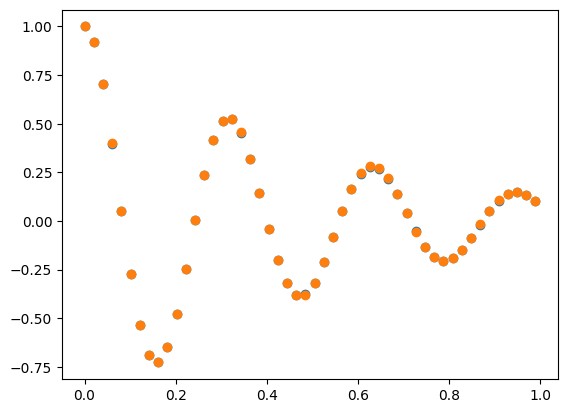

In [14]:
dx = jax.vmap(best_model)(ts)


plt.scatter(ts, dx)
plt.scatter(ts, xs)

# PI-DeepONet

In [2]:
from typing import Callable

class DeepOnet(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self, 
        in_branch: int,
        in_trunk: int,
        width: int,
        depth: int,
        interact: int,
        activation: Callable,
        *,
        key
    ):
        """
        Simplified deeponet using twin hidden architectures
        """

        b_key, t_key = jax.random.split(key)

        self.branch_net = eqx.nn.MLP(
            in_branch,
            interact,
            width,
            depth,
            activation,
            key=b_key
        )

        self.trunk_net = eqx.nn.MLP(
            in_trunk,
            interact,
            width,
            depth,
            activation,
            final_activation=activation,
            key=b_key
        )

        self.bias = jnp.zeros((1,))

    
    def __call__(self, x_trunk, x_branch):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """

        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)

        inner_product = jnp.sum(branch_out*trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]
        
    

## Loading data

In [3]:
with h5py.File("../../outputs/damped_pendulum_simulations.h5", "r") as f:
    size = f["parameters"].shape[0]


key = jax.random.key(14)
idx = jnp.sort(jax.random.choice(key, jnp.arange(0, size), shape=(25_000,), replace=False))



with h5py.File("../../outputs/damped_pendulum_simulations.h5", "r") as f:
    
    print(f.keys())
    parameters = jnp.array(f["parameters"])[idx]
    simulations = jnp.array(f["simulations"][idx, 0])
    time = jnp.array(f["time"]).reshape(-1, 1)
    

<KeysViewHDF5 ['parameters', 'simulations', 'time']>


# Setting training up

In [5]:
def loss_fn(model):
    outputs = jax.vmap(jax.vmap(model, in_axes=(None, 0)), in_axes=(0, None))(parameters, time)
    mse = jnp.mean(jnp.square(outputs - simulations))
    return mse

def ode(model, X, parameters):
    """Pendulum mass-spring ODE"""
    
    x, x_t = eqx.filter_value_and_grad(model)(X, parameters)
    x_tt = eqx.filter_grad(lambda x, parameters: eqx.filter_grad(model)(x, parameters)[0])(X, parameters)
    ode = x_tt + parameters[1]*x_t + parameters[0]*x
    
    return ode


def loss_fn_physics(model, parameters, X):
    
    outputs = jax.vmap(jax.vmap(model, in_axes=(None, 0)), in_axes=(0, None))(X, parameters)
    mse = jnp.mean(jnp.square(outputs - simulations))
    physics = jnp.mean(
        jnp.square(
            jax.vmap(jax.vmap(ode, in_axes=(None, None, 0)), in_axes=(None, 0, None))(model, X, parameters)
        ))

    return mse + physics



@eqx.filter_jit
def update(opt_state, model):
    
    loss, grad = eqx.filter_value_and_grad(loss_fn_physics)(model, parameters, time)
    updates, new_state = optmizer.update(grad, opt_state, model)
    new_model = eqx.apply_updates(model, updates)

    return loss, new_model, new_state



deeponet = DeepOnet(
    4,
    1,
    64,
    6,
    32,
    activation=jax.nn.silu,
    key=jax.random.key(463)
)


losses = []

In [6]:
physics = jax.vmap(
    jax.vmap(ode, in_axes=(None, None, 0)),
    in_axes=(None, 0, None)
)(deeponet, time, parameters)jax.config.update('jax_default_device', jax.devices('cpu')[0])


    

In [ ]:
from copy import deepcopy

optmizer = optax.adam(0.001)
opt_state = optmizer.init(eqx.filter(deeponet, eqx.is_array))

min_loss = min(losses) if losses else 1_000_000

for epoch in range(100_000):

    loss, deeponet, opt_state = update(opt_state, deeponet)

    losses.append(loss)

    if epoch % 100 == 0:
        print(f"{epoch = } | {loss = }")

    if loss <= min_loss:
        print(f"Best model  at step: {len(losses)} | {loss = }")
        best_model = deepcopy(deeponet)
        min_loss = loss